# Movement recognition 

The human movement recognition is based on the assumption that specific body movements obtained from on-body or ambient sensors translate into specific signal patterns, which can be identified/classified using machine learning or deep learning techniques.

In the notebook is used K-means Clustering for Time Series with Dynamic Time Warping.

# Loading the dataset

In [50]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") 

In [51]:
from tslearn.metrics import soft_dtw
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import silhouette_score

In [52]:
df_train=pd.read_csv(r'data\\unlabeled\\063-COMBINED-2022-10-26-7-52-10-1666800984-v1.4.3+lucina-buzz.csv')
df_train.shape

(742383, 29)

In [53]:
df_train_short = df_train.iloc[3000:15000]
df_train_short.head(5)

,Unnamed: 0,ts_r,acc_x_r,acc_y_r,acc_z_r,temp_r,gyr_x_r,gyr_y_r,gyr_z_r,mag_x_r,...,temp_n,gyr_x_n,gyr_y_n,gyr_z_n,mag_x_n,mag_y_n,mag_z_n,kal_status_n,alpha_n,beta_n
3000,3000,1229359.0,0.985107,-0.093750,-0.309570,3056.0,14.587402,-0.305176,-4.241943,-1313.0,...,2416.0,19.073486,1.892090,-10.162354,13124.0,-2462.0,-16583.0,1.0,-705.0,1792.0
3001,3001,1229360.0,0.983887,-0.096924,-0.312744,3136.0,14.648438,0.274658,-4.364014,-1313.0,...,2464.0,18.280029,2.380371,-10.131836,13105.0,-2581.0,-16639.0,1.0,-705.0,1792.0
3002,3002,1229361.0,0.975830,-0.103516,-0.307617,3024.0,14.465332,0.579834,-3.906250,-1294.0,...,2384.0,16.479492,1.159668,-9.735107,13105.0,-2581.0,-16639.0,1.0,-705.0,1792.0
3003,3003,1229362.0,0.981689,-0.107178,-0.306152,3120.0,13.214111,0.518799,-3.997803,-1294.0,...,2464.0,15.167236,1.586914,-9.796143,13097.0,-2722.0,-16781.0,1.0,-705.0,1792.0
3004,3004,1229363.0,0.977539,-0.112549,-0.307373,3072.0,11.383057,0.274658,-4.425049,-1275.0,...,2464.0,12.756348,1.129150,-8.728027,13097.0,-2722.0,-16781.0,1.0,-705.0,1792.0


In [54]:
df_train_short =df_train_short.reset_index()

In [55]:
df_train_short.columns

Index(['index', 'Unnamed: 0', 'ts_r', 'acc_x_r', 'acc_y_r', 'acc_z_r',
       'temp_r', 'gyr_x_r', 'gyr_y_r', 'gyr_z_r', 'mag_x_r', 'mag_y_r',
       'mag_z_r', 'kal_status_r', 'alpha_r', 'beta_r', 'ts_n', 'acc_x_n',
       'acc_y_n', 'acc_z_n', 'temp_n', 'gyr_x_n', 'gyr_y_n', 'gyr_z_n',
       'mag_x_n', 'mag_y_n', 'mag_z_n', 'kal_status_n', 'alpha_n', 'beta_n'],
      dtype='object')

In [56]:
# Dataset to compare kal_status_r with cluster
scale_columns_kal_status =['acc_x_n', 'acc_y_n', 'acc_z_n', 'alpha_r', 'beta_r', 'kal_status_r']
df_train_kalstatus=df_train_short[scale_columns_kal_status]

In [57]:
# Create the training dataset
scale_columns = ['acc_x_n', 'acc_y_n', 'acc_z_n', 'alpha_r', 'beta_r']
df_train_short=df_train_short[scale_columns]

In [58]:
df_train_short.head(2)

,acc_x_n,acc_y_n,acc_z_n,alpha_r,beta_r
0,0.780762,-0.000244,-0.664795,-15950.0,-16134.0
1,0.779785,-0.016602,-0.665283,-16008.0,-16055.0


# Dimensionality reduction
Converting the DataFrame into 2D features frame for visualization

In [59]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_train_short)
pca_df = pd.DataFrame(data=principal_components ,columns=["PCA1","PCA2"])
pca_df

,PCA1,PCA2
0,-849.839618,-42.905288
1,-830.123793,-138.906779
2,-843.464057,-225.249337
3,-843.464056,-225.249336
4,-843.464057,-225.249337
...,...,...
11995,-758.111494,692.390542
11996,-646.416808,681.746464
11997,-567.350283,672.286837
11998,-567.350278,672.286841


TimeSeriesScalerMeanVariance: This scaler is such that each output time series has zero mean and unit variance. The assumption here is that the range of a given time series is uninformative and one only wants to compare shapes in an amplitude-invariant manner (when time series are multivariate, this also rescales all modalities such that there will not be a single modality responsible for a large part of the variance). This means that one cannot scale barycenters back to data range because each time series is scaled independently and there is hence no such thing as an overall data range.

3D array of shape (n_ts, sz, d) with the following conventions:
- the fist axis is the sample axis, n_ts being the number of time series;
- the second axis is the time axis, sz being the maximum number of time points;
- the third axis is the dimension axis, d being the number of dimensions.

In [60]:
random_seed = 42
np.random.seed(random_seed)
X_train = TimeSeriesScalerMeanVariance().fit_transform(df_train_short) 
print(X_train.shape)  

(12000, 5, 1)


# Model Building using KMeans

In [115]:
print("Soft-DTW k-means") 
# BEST SILHOUETTE SCORE for: k= 16, k= 11, k=5
sdtw_km = TimeSeriesKMeans(n_clusters=6,
                           metric="softdtw",
                           n_init=2,
                           metric_params={"gamma": .01},
                           verbose=True,
                           max_iter=10,                    
                           random_state=random_seed)
sdtw_km.fit(X_train)


Soft-DTW k-means
Init 1
0.001 --> 0.001 --> 0.001 --> 0.001 --> 
Init 2
0.001 --> 0.001 --> 0.001 --> 0.001 --> 


TimeSeriesKMeans(max_iter=10, metric='softdtw', metric_params={'gamma': 0.01},
                 n_clusters=6, n_init=2, random_state=42, verbose=True)

In [116]:
# Add cluster labels to the PCA DataFrame for vizualization
pca_df_kmeans= pd.concat([pca_df,pd.DataFrame({'cluster':sdtw_km.labels_})],axis=1)
pca_df_kmeans.shape

(12000, 3)

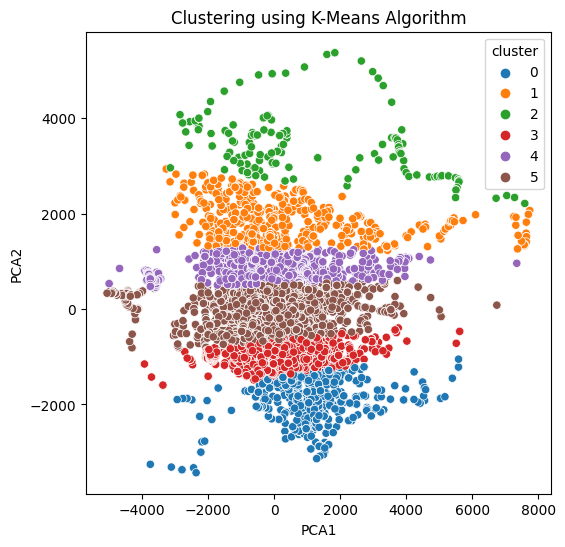

In [117]:
# N_CLUSTERS == 6
plt.figure(figsize=(6,6))
palette= sns.color_palette()
ax=sns.scatterplot(x="PCA1",y="PCA2",hue="cluster",data=pca_df_kmeans, palette=palette)
plt.title("Clustering using K-Means Algorithm")
plt.show()

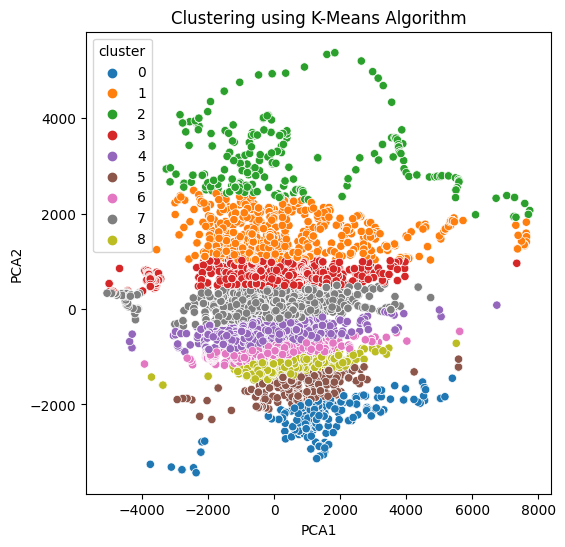

In [79]:
# N_CLUSTERS == 9
plt.figure(figsize=(6,6))
palette= sns.color_palette()
ax=sns.scatterplot(x="PCA1",y="PCA2",hue="cluster",data=pca_df_kmeans, palette=palette)
plt.title("Clustering using K-Means Algorithm")
plt.show()

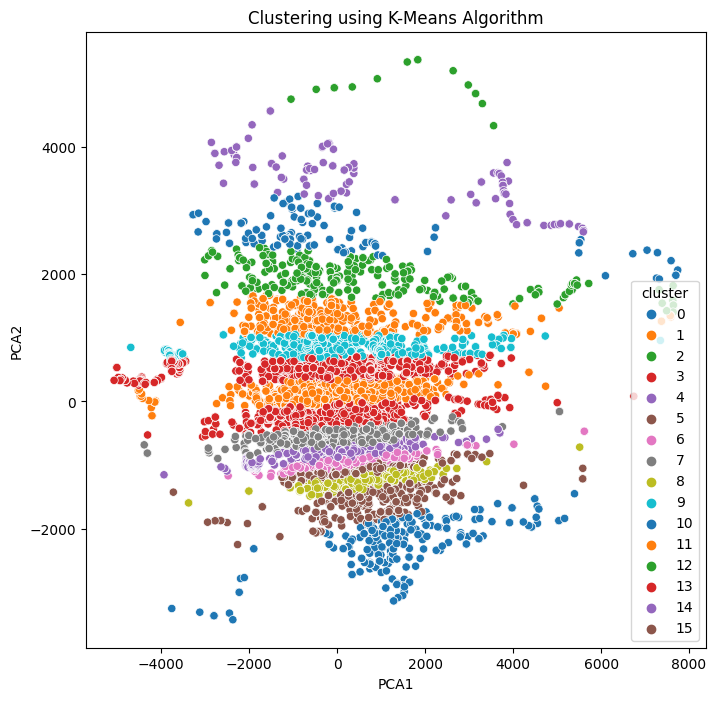

In [74]:
# N_CLUSTERS == 16
plt.figure(figsize=(8,8))
palette= sns.color_palette()
ax=sns.scatterplot(x="PCA1",y="PCA2",hue="cluster",data=pca_df_kmeans, palette=palette)
plt.title("Clustering using K-Means Algorithm")
plt.show()

In [80]:
np.unique(sdtw_km.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([ 347, 1184,  403, 1574, 2361,  435, 1076, 3844,  776], dtype=int64))

# Find all cluster centers

In [118]:
centroids_2D = sdtw_km.cluster_centers_
centroids_2D

array([[[ 0.81123403],
        [ 0.81116792],
        [ 0.81110641],
        [-1.39194244],
        [-1.04160944]],

       [[ 0.81104542],
        [ 0.81099057],
        [ 0.81092725],
        [-1.03542637],
        [-1.39735329]],

       [[ 0.79699567],
        [ 0.79694743],
        [ 0.79687982],
        [-0.85652293],
        [-1.53404584]],

       [[ 0.81546756],
        [ 0.81540286],
        [ 0.81534152],
        [-1.2867917 ],
        [-1.15947043]],

       [[ 0.8151621 ],
        [ 0.81509829],
        [ 0.81503282],
        [-1.1417408 ],
        [-1.30349638]],

       [[ 0.81640794],
        [ 0.81634829],
        [ 0.81629008],
        [-1.2214539 ],
        [-1.227613  ]]])

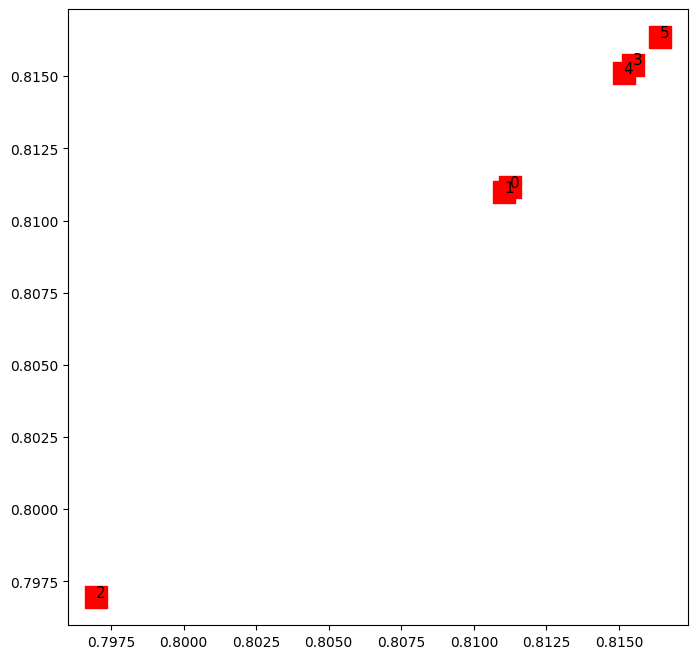

In [120]:
#CENTROIDS FOR 6 CLUSTERS
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', s=250, marker='s')
for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=11)

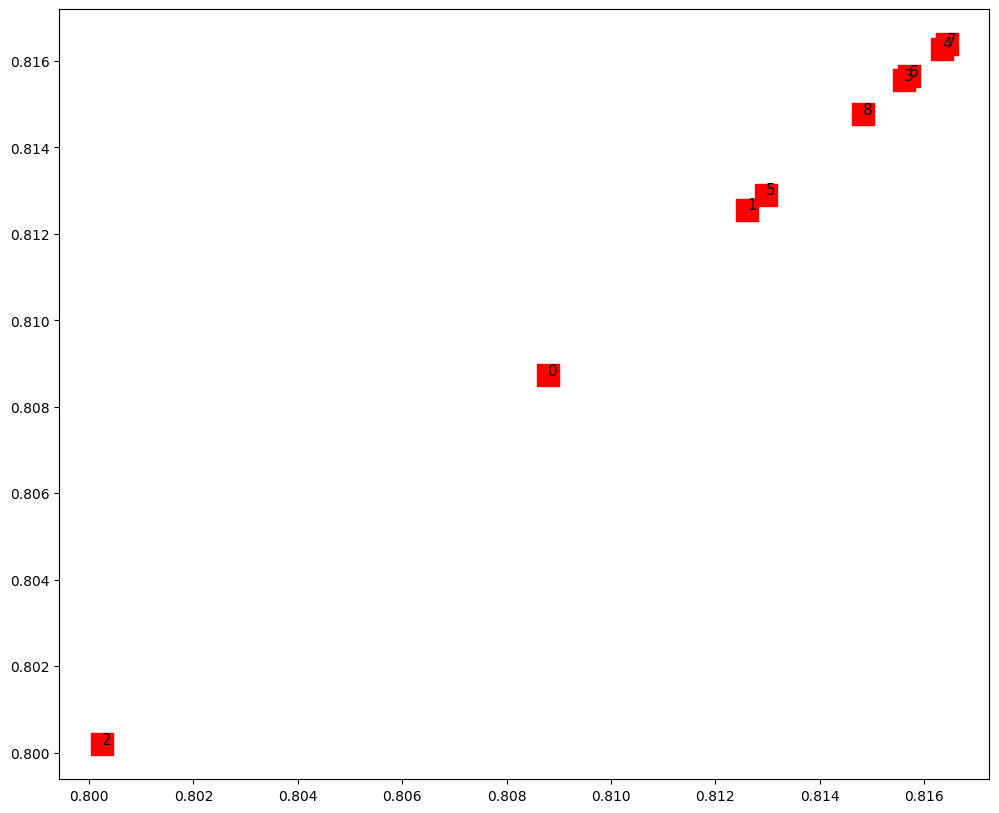

In [87]:
#CENTROIDS FOR 9 CLUSTERS
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(centroids_2D[:,0], centroids_2D[:,1], c='r', s=250, marker='s')
for i in range(len(centroids_2D)):
    plt.annotate(i, (centroids_2D[i][0], centroids_2D[i][1]), fontsize=11)


# Saving the kmeans clustering model and the data with cluster label

In [88]:
#Saving Scikitlearn models
import joblib
joblib.dump(sdtw_km, "soft_dtw_kmeans_model.pkl")

['soft_dtw_kmeans_model.pkl']

In [121]:
from tslearn.utils import to_sklearn_dataset
cluster_df_sk = to_sklearn_dataset(X_train)
cluster_df_sk
df = pd.DataFrame(cluster_df_sk, columns =df_train_short.columns)
df.head()

,acc_x_n,acc_y_n,acc_z_n,alpha_r,beta_r
0,0.816569,0.816469,0.816385,-1.213005,-1.236417
1,0.816590,0.816489,0.816406,-1.221751,-1.227735
2,0.816588,0.816487,0.816404,-1.229447,-1.220032
3,0.816587,0.816487,0.816404,-1.229447,-1.220032
4,0.816587,0.816487,0.816404,-1.229447,-1.220032


In [122]:
cluster_df = pd.concat([df, pd.DataFrame({'cluster':sdtw_km.labels_})],axis=1)
cluster_df.head()

,acc_x_n,acc_y_n,acc_z_n,alpha_r,beta_r,cluster
0,0.816569,0.816469,0.816385,-1.213005,-1.236417,5
1,0.816590,0.816489,0.816406,-1.221751,-1.227735,5
2,0.816588,0.816487,0.816404,-1.229447,-1.220032,5
3,0.816587,0.816487,0.816404,-1.229447,-1.220032,5
4,0.816587,0.816487,0.816404,-1.229447,-1.220032,5


In [123]:
cluster_1_df = cluster_df[cluster_df["cluster"]==1]
cluster_1_df

,acc_x_n,acc_y_n,acc_z_n,alpha_r,beta_r,cluster
326,0.812660,0.812642,0.812468,-1.064403,-1.373368,1
327,0.812236,0.812215,0.812041,-1.055579,-1.380913,1
328,0.812231,0.812215,0.812046,-1.055579,-1.380913,1
329,0.812234,0.812216,0.812042,-1.055580,-1.380913,1
330,0.812230,0.812219,0.812044,-1.055579,-1.380913,1
...,...,...,...,...,...,...
11796,0.811050,0.811024,0.810869,-1.033004,-1.399940,1
11797,0.813190,0.813147,0.813023,-1.076028,-1.363331,1
11798,0.813191,0.813140,0.813029,-1.076029,-1.363330,1
11799,0.813190,0.813138,0.813032,-1.076030,-1.363330,1


In [92]:
cluster_df.to_csv("Clustered_Movement_Data.csv")

# Evaluate the model

In [108]:
ss = metrics.silhouette_score(cluster_df_sk, sdtw_km.labels_)  
print('Parameter: 9 clusters',  'Score: ', ss)

Parameter: 9 clusters Score:  0.4832941596713616


In [124]:
ss = metrics.silhouette_score(cluster_df_sk, sdtw_km.labels_)  
print('Parameter: 6 clusters',  'Score: ', ss)

Parameter: 6 clusters Score:  0.47650265694189


In [106]:
possible_k_values = range(2, 12)

In [107]:
sum_of_squared_distances = []

for k in possible_k_values:
    k_means = TimeSeriesKMeans(n_clusters=k)
    k_means = k_means.fit(X_train)

    sum_of_squared_distances.append(k_means.inertia_)
    
sum_of_squared_distances[:20]

[0.00947702584910573,
 0.004983838958151097,
 0.003161465748617611,
 0.002082262988607674,
 0.001502762914781969,
 0.001322837616021067,
 0.0008148815967655653,
 0.0006900827761168145,
 0.0005734910056130493,
 0.0005044925921538127]

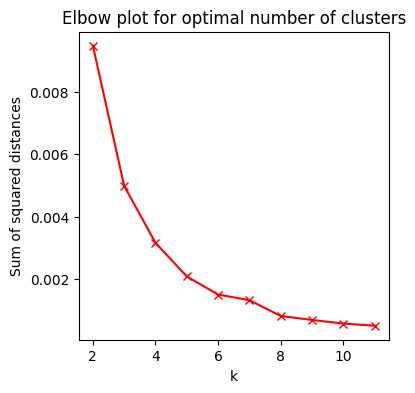

In [109]:
fig, ax = plt.subplots(figsize=(4, 4))

plt.plot(possible_k_values, sum_of_squared_distances, 'rx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')

plt.title('Elbow plot for optimal number of clusters')
plt.show()

In [110]:
scores_df = pd.DataFrame({'k_value' : possible_k_values,
                          'score' : sum_of_squared_distances})

scores_df.head(10)

,k_value,score
0,2,0.009477
1,3,0.004984
2,4,0.003161
3,5,0.002082
4,6,0.001503
5,7,0.001323
6,8,0.000815
7,9,0.000690
8,10,0.000573
9,11,0.000504


In [111]:
def silhouette_score_kmeans(k, data):
    kmean = TimeSeriesKMeans(n_clusters = k).fit(data)
    
    silhou_score = silhouette_score(data, kmean.labels_)

    return silhou_score

In [112]:
silhouette_score_per_k = []

for k in possible_k_values:
    silhou_score = silhouette_score_kmeans(k, cluster_df_sk)
    
    silhouette_score_per_k.append(silhou_score)
    
silhouette_score_per_k[:20]

[0.5247026677754891,
 0.5337415536354003,
 0.5172781375351269,
 0.5330494860992532,
 0.5362978008355775,
 0.5291723360759536,
 0.537349075296652,
 0.5368258802688881,
 0.5321480144346601,
 0.531226259630908]

In [113]:
scores_df = pd.DataFrame({'k_value' : possible_k_values,
                          'score' : silhouette_score_per_k})

scores_df.head(10)

,k_value,score
0,2,0.524703
1,3,0.533742
2,4,0.517278
3,5,0.533049
4,6,0.536298
5,7,0.529172
6,8,0.537349
7,9,0.536826
8,10,0.532148
9,11,0.531226


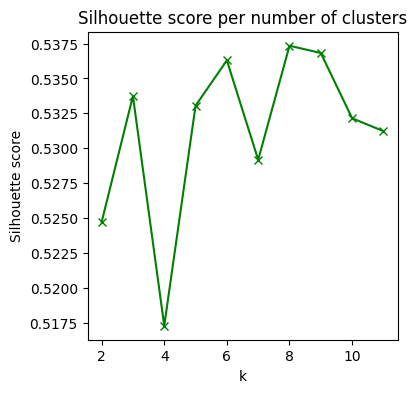

In [114]:
fig, ax = plt.subplots(figsize=(4, 4))

plt.plot(possible_k_values, silhouette_score_per_k, 'gx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')

plt.title('Silhouette score per number of clusters')
plt.show()